# Problem statement:
We want to build a surrogate model with a Convolutional Recurrent NN architecture to learn and predict the time-evolution of a bi-dimensional phase-field.
It will be supplied as an image (npy array) with $n \times n$ pixels. The convolutional architecture helps us capturing the local correlations between nearby correlated pixels, while the recurrent architecture helps us better learn the temporal evolution.

## Step 3

We consider a system with two interacting pixels. 
Given pixel concentrations $A_t, B_t$, and $\Delta_t = A_t - B_t$, the time-evolution is governed by a mixing law:
$$
A_{t+1} = A_t - \Delta_t \, B_t \, \alpha \, dt \\
B_{t+1} = B_t + \Delta_t \, A_t \, \alpha \, dt
$$


We import some useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We use the same parameters and function to compute the time-evolution

In [2]:
alpha = 0.05 # scaling factor
dt = 1 # integration time-step
T = 100 # number of time steps
x0 = np.array([1, 0]) # initial condition
t = np.arange(T+1) # time
x = np.zeros((2, T+1)) # scalar to evolve

In [3]:
# function defining the time-evolution
def propagate(x, alpha, dt):
    #x_i = x*(1 - np.cos((x-1)*np.pi)*alpha*dt) + 0.005*dt
    x_i = np.zeros(2)
    x_i[0] = x[0] - (x[0]-x[1])*x[1]*alpha*dt
    x_i[1] = x[1] - (x[1]-x[0])*x[0]*alpha*dt
    
    return x_i

Let's check a bunch of starting conditions

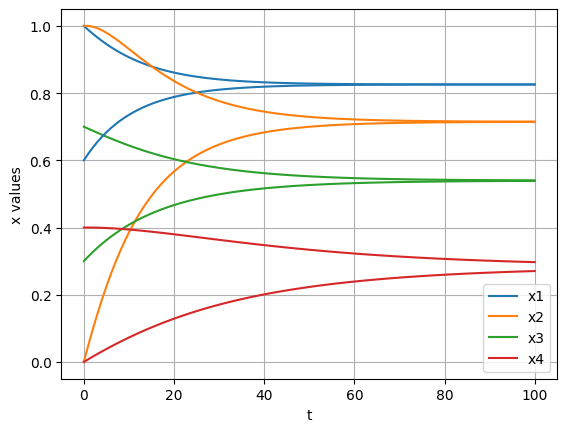

In [4]:
# checking the behaviour formultiple starting conditions
x1 = np.zeros((2, T+1))
x2 = np.zeros((2, T+1))
x3 = np.zeros((2, T+1))
x4 = np.zeros((2, T+1))
x1[:, 0] = [1.0, 0.6]
x2[:, 0] = [0.0, 1.0]
x3[:, 0] = [0.7, 0.3]
x4[:, 0] = [0.0, 0.4]

for i in range(1, T+1):
    x1[:, i] = propagate(x1[:, i-1], alpha, dt)
    x2[:, i] = propagate(x2[:, i-1], alpha, dt)
    x3[:, i] = propagate(x3[:, i-1], alpha, dt)
    x4[:, i] = propagate(x4[:, i-1], alpha, dt)

plt.plot(t, x1[0, :], label='x1')
plt.plot(t, x2[0, :], label='x2')
plt.plot(t, x3[0, :], label='x3')
plt.plot(t, x4[0, :], label='x4')
plt.plot(t, x1[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(t, x2[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(t, x3[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
plt.plot(t, x4[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
plt.xlabel('t')
plt.ylabel('x values')
plt.legend()
plt.grid()
#plt.yscale('log')

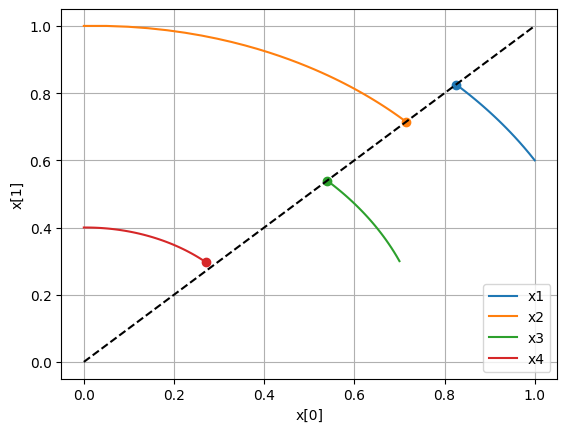

In [5]:
plt.plot(x1[0, :], x1[1, :], label='x1')
plt.plot(x2[0, :], x2[1, :], label='x2')
plt.plot(x3[0, :], x3[1, :], label='x3')
plt.plot(x4[0, :], x4[1, :], label='x4')

plt.plot(x1[0, -1], x1[1, -1], marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(x2[0, -1], x2[1, -1], marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(x3[0, -1], x3[1, -1], marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
plt.plot(x4[0, -1], x4[1, -1], marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.legend()
plt.grid()

Ok, let's try to learn such dynamics.

First of all we create a dataset of conditions, and we want to predict the next step.

In [115]:
# function defining the time-evolution
def propagator(x, alpha, dt):
    x_i = np.zeros(x.shape)

    if len(x.shape) == 1:
        x_i[0] = x[0] - (x[0]-x[1])*x[1]*alpha*dt
        x_i[1] = x[1] - (x[1]-x[0])*x[0]*alpha*dt
    else:
        x_i[:, 0] = x[:, 0] - (x[:, 0]-x[:, 1])*x[:, 1]*alpha*dt
        x_i[:, 1] = x[:, 1] - (x[:, 1]-x[:, 0])*x[:, 0]*alpha*dt
    
    return x_i

In [114]:
len(x.shape)

2

In [78]:
x = np.random.rand(1000, 2) # starting point
y = propagator(x, alpha, dt)   

d = y-x

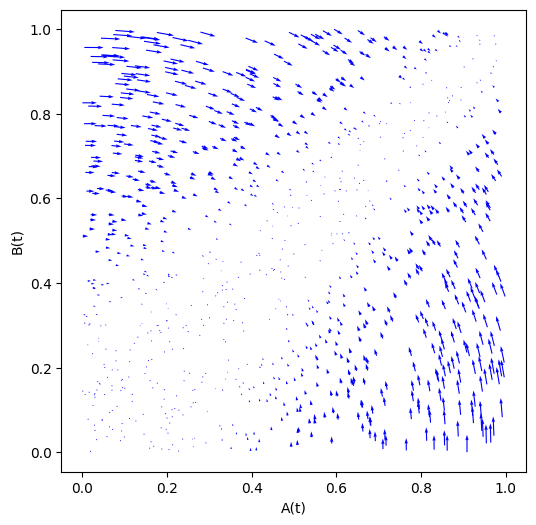

In [80]:
# Compute vector components
u = y[:, 0] - x[:, 0]   # delta x
v = y[:, 1] - x[:, 1]   # delta y

# Plot vector field
plt.figure(figsize=(6,6))
plt.quiver(x[:, 0], x[:, 1], u, v, angles='xy', scale_units='xy', scale=1, color='blue')
#plt.scatter(x[0, :], x[1, :], color='red', label='Tails')
#plt.scatter(y[0, :], y[1, :], color='green', label='Heads')
plt.xlabel('A(t)')
plt.ylabel('B(t)')
plt.axis('equal')
plt.show()

Let's import the libraries to build such NN model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [81]:
def generate_dataset(N, alpha=alpha, dt=dt):
    x = np.random.rand(N, 2) # starting point
    y = propagator(x, alpha, dt)   
    d = y-x 

    np.save('x.npy', x)
    np.save('y.npy', y)
    np.save('d.npy', d)

    # =========================
    # 1. Load dataset
    # =========================
    X = np.load("x.npy")  
    y = np.load("d.npy")    

    #X = X.reshape(-1, 1)
    #y = y.reshape(-1, 1)

    # Fit scaler on y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    # Wrap into dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # =========================
    # 2. Train-validation split
    # =========================
    val_ratio = 0.2
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    return train_dataset, val_dataset, train_loader, val_loader, y_scaler

    

In [82]:
def new_model(in_dim, out_dim, act_fun, my_nn, lr, epochs, train_loader, val_loader):
    class Net(nn.Module):
        def __init__(self, in_dim, out_dim):  
            super(Net, self).__init__()
            if len(my_nn) == 1:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], out_dim),
                    )

            if len(my_nn) == 2:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ReLU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ELU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.Tanh(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
        
        def forward(self, x):
            return self.layers(x)

    model = Net(in_dim, out_dim)

    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_tra_saved = np.empty(epochs)
    loss_val_saved = np.empty(epochs)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view_as(preds))  # reshape if needed
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb.view_as(preds))
                val_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
    
        loss_tra_saved[epoch] = train_loss / len(train_loader)
        loss_val_saved[epoch] = val_loss / len(val_loader)

    torch.save(model.state_dict(), "model.pth")

    saved_model = Net(in_dim, out_dim)
    saved_model.load_state_dict(torch.load("model.pth"))
    saved_model.eval()

    return loss_tra_saved, loss_val_saved, saved_model

In [83]:
def plot_loss(epochs, loss_tra_saved, loss_val_saved):
    plt.plot(range(epochs), loss_tra_saved, label='training')
    plt.plot(range(epochs), loss_val_saved, label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

In [84]:
def subset_to_numpy(subset):
    X = torch.stack([subset[i][0] for i in range(len(subset))])
    y = torch.stack([subset[i][1] for i in range(len(subset))])
    
    return X.numpy(), y.numpy()

In [95]:
def next_step_pred(train_dataset, val_dataset, saved_model):
    X_train, y_train = subset_to_numpy(train_dataset)
    X_val, y_val     = subset_to_numpy(val_dataset)
    
    with torch.no_grad():
        y_pred_val = saved_model(torch.tensor(X_val, dtype=torch.float32)).numpy()

    actual_y_val  = y_scaler.inverse_transform(y_val)
    actual_y_pred = y_scaler.inverse_transform(y_pred_val)

    # Compute vector components
    u_val  = actual_y_val[:, 0]  
    v_val  = actual_y_val[:, 1]    
    u_pred = actual_y_pred[:, 0]  
    v_pred = actual_y_pred[:, 1] 

    # Plot vector field
    plt.figure(figsize=(10,10))
    #plt.scatter(X_val[:, 0], X_val[:, 1])
    plt.quiver(X_val[:, 0], X_val[:, 1], u_pred, v_pred, angles='xy', scale_units='xy', scale=.3, color='red', label='Predicted')
    plt.quiver(X_val[:, 0], X_val[:, 1], u_val,  v_val,  angles='xy', scale_units='xy', scale=.3, color='blue', label='Validation')
    plt.xlabel('A(t)')
    plt.ylabel('B(t)')
    plt.axis('equal')
    plt.legend()
    plt.title("Model Fit on Test Data")
    plt.grid()

In [ ]:
def predict_dynamics(alpha, dt, y_scaler, saved_model):
    T = 1000
    t = np.arange(T+1)
    x1_true = np.zeros((T+1, 2))
    x2_true = np.zeros((T+1, 2))
    x3_true = np.zeros((T+1, 2))
    x4_true = np.zeros((T+1, 2))

    x1_true[0, :] = [1.0, 0.6]
    x2_true[0, :] = [0.0, 1.0]
    x3_true[0, :] = [0.7, 0.3]
    x4_true[0, :] = [0.0, 0.4]

    x1_pred = np.zeros((T+1, 2))
    x2_pred = np.zeros((T+1, 2))
    x3_pred = np.zeros((T+1, 2))
    x4_pred = np.zeros((T+1, 2))

    x1_pred[0, :] = [1.0, 0.6]
    x2_pred[0, :] = [0.0, 1.0]
    x3_pred[0, :] = [0.7, 0.3]
    x4_pred[0, :] = [0.0, 0.4]

    for i in range(1, T+1):
        x1_true[i, :] = propagator(x1_true[i-1, :], alpha, dt)
        x2_true[i, :] = propagator(x2_true[i-1, :], alpha, dt)
        x3_true[i, :] = propagator(x3_true[i-1, :], alpha, dt)
        x4_true[i, :] = propagator(x4_true[i-1, :], alpha, dt)

    with torch.no_grad():
        for i in range(1, T+1):        
            # add "unsqueeze(0)" because it transforms from (2,) to (1, 2) cosistent with the model's input
            x1_pred[i, :] = x1_pred[i-1, :] + y_scaler.inverse_transform(
                saved_model(torch.tensor(x1_pred[i-1, :], dtype=torch.float32).unsqueeze(0)).numpy())
            x2_pred[i, :] = x2_pred[i-1, :] + y_scaler.inverse_transform(
                saved_model(torch.tensor(x2_pred[i-1, :], dtype=torch.float32).unsqueeze(0)).numpy())
            x3_pred[i, :] = x3_pred[i-1, :] + y_scaler.inverse_transform(
                saved_model(torch.tensor(x3_pred[i-1, :], dtype=torch.float32).unsqueeze(0)).numpy())
            x4_pred[i, :] = x4_pred[i-1, :] + y_scaler.inverse_transform(
                saved_model(torch.tensor(x4_pred[i-1, :], dtype=torch.float32).unsqueeze(0)).numpy())

    first_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    second_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    third_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
    fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

    plt.figure(figsize=(15,10))

    plt.plot(t, x1_true[:, 0], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 0], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 0], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 0], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 0], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 0], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 0], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 0], '-', label="x4_pred", color=fourth_color)

    plt.plot(t, x1_true[:, 1], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 1], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 1], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 1], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 1], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 1], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 1], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 1], '-', label="x4_pred", color=fourth_color)

    plt.xlabel('t')
    plt.ylabel('x values')
    #plt.legend()
    plt.grid()

What works:
- dataset size: 500
- train val split: 0.20
- layers/neurons: [3]
- activation functions: Tanh
- learning rate: 0.001
- epochs: 3000

In [107]:
N = 1000
in_dim = 2
out_dim = 2
act_fun = 'Tanh'
my_nn = [2]
lr = 0.001
epochs = 1000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

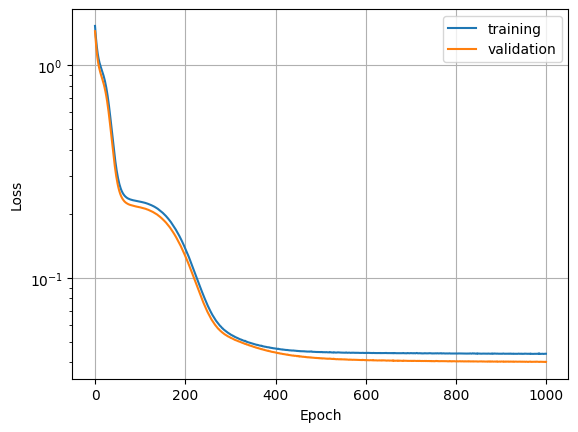

In [109]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

In [110]:
x_test = np.random.rand(500, 2) # starting point
x_next_test = propagator(x_test, alpha, dt)  

y_test = x_next_test - x_test

# Fit scaler on y
y_test_scaled = y_scaler.transform(y_test)

# Convert to PyTorch tensors
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

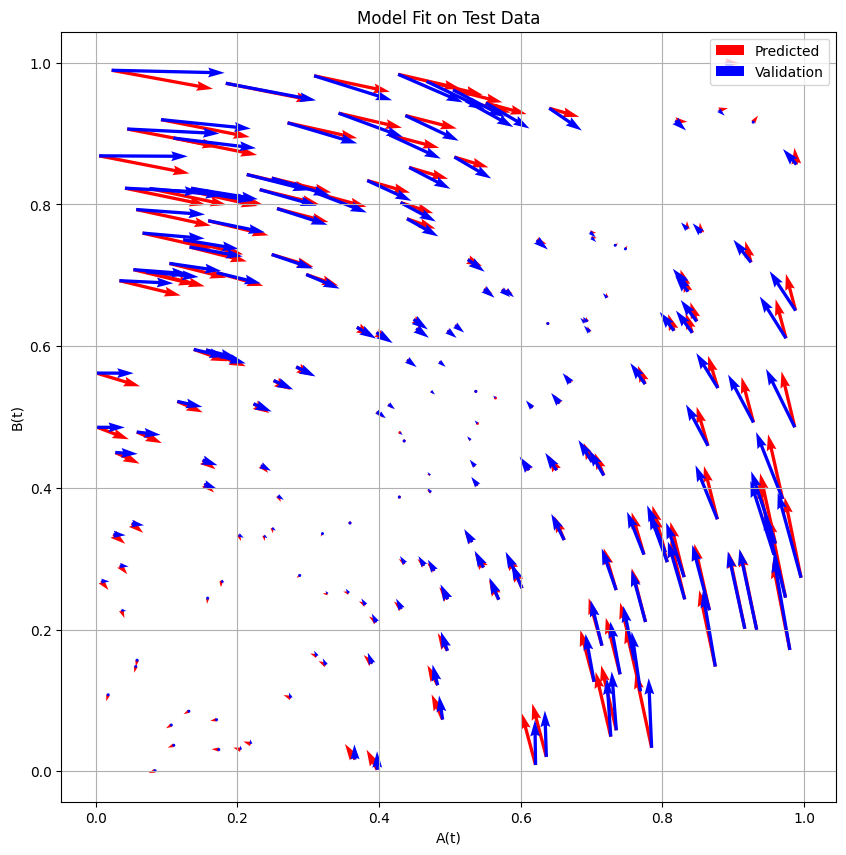

In [111]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model)

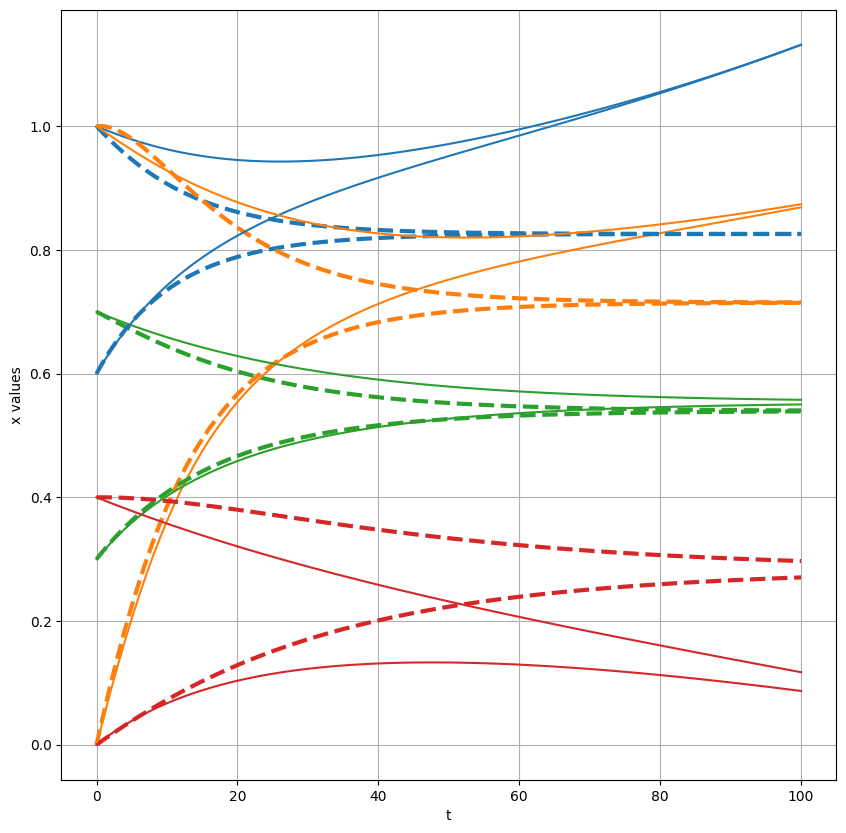

In [140]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

Not good, but we can definetly do better by increasing the number of neurons

In [141]:
N = 1000
in_dim = 2
out_dim = 2
act_fun = 'Tanh'
my_nn = [5]
lr = 0.001
epochs = 3000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

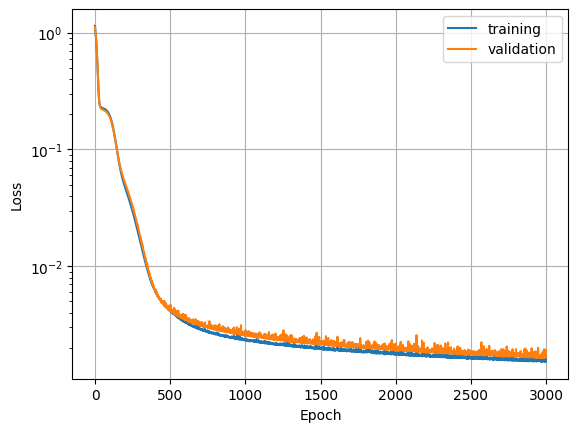

In [143]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

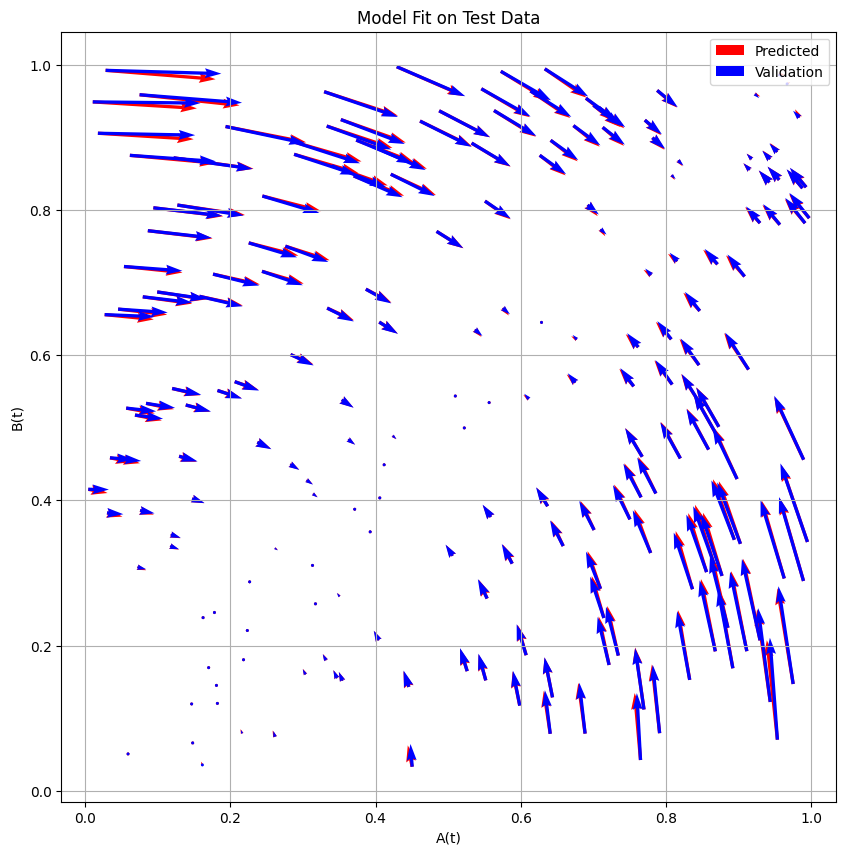

In [144]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model)

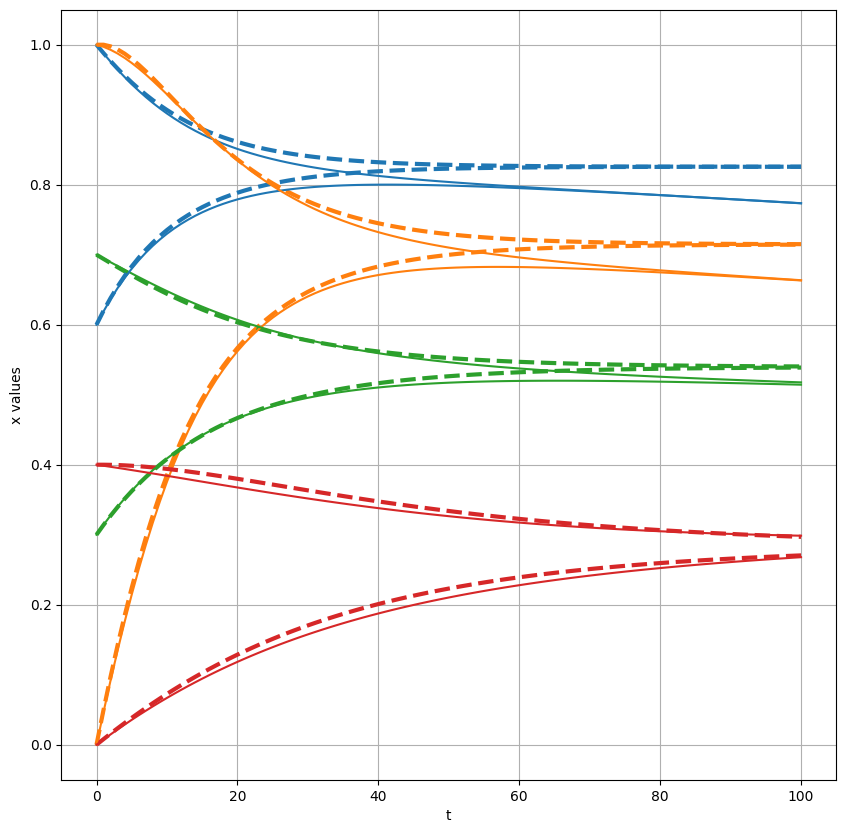

In [145]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

It doesn't fit too bad, but still we get these big errors in dynamics... Quite unexpcted.

We can try fit even better!


In [147]:
N = 1000
in_dim = 2
out_dim = 2
act_fun = 'Tanh'
my_nn = [16, 8]
lr = 0.001
epochs = 5000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

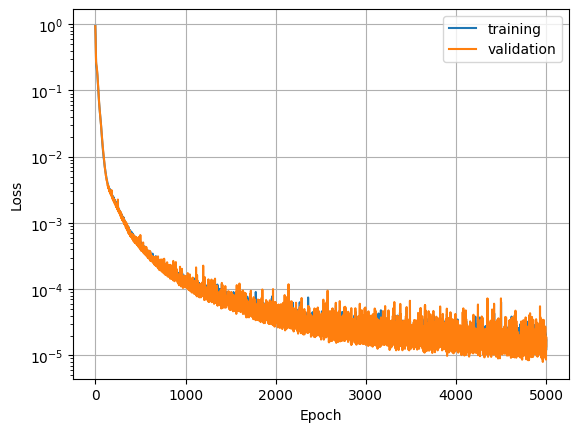

In [149]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

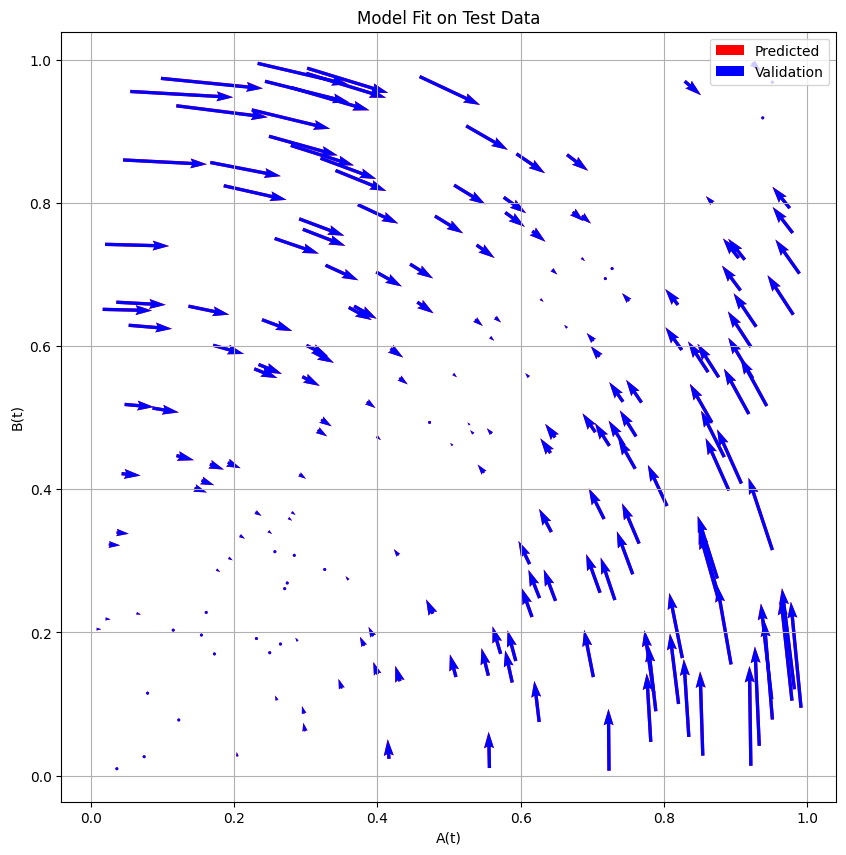

In [150]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model)

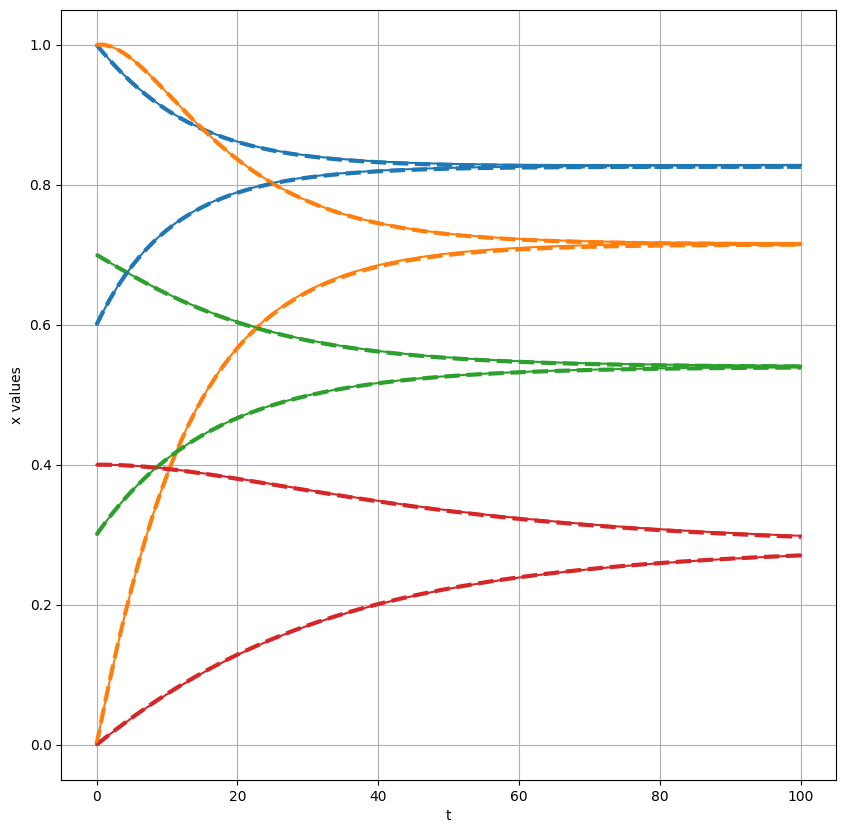

In [151]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

Let's check the long time behaviour

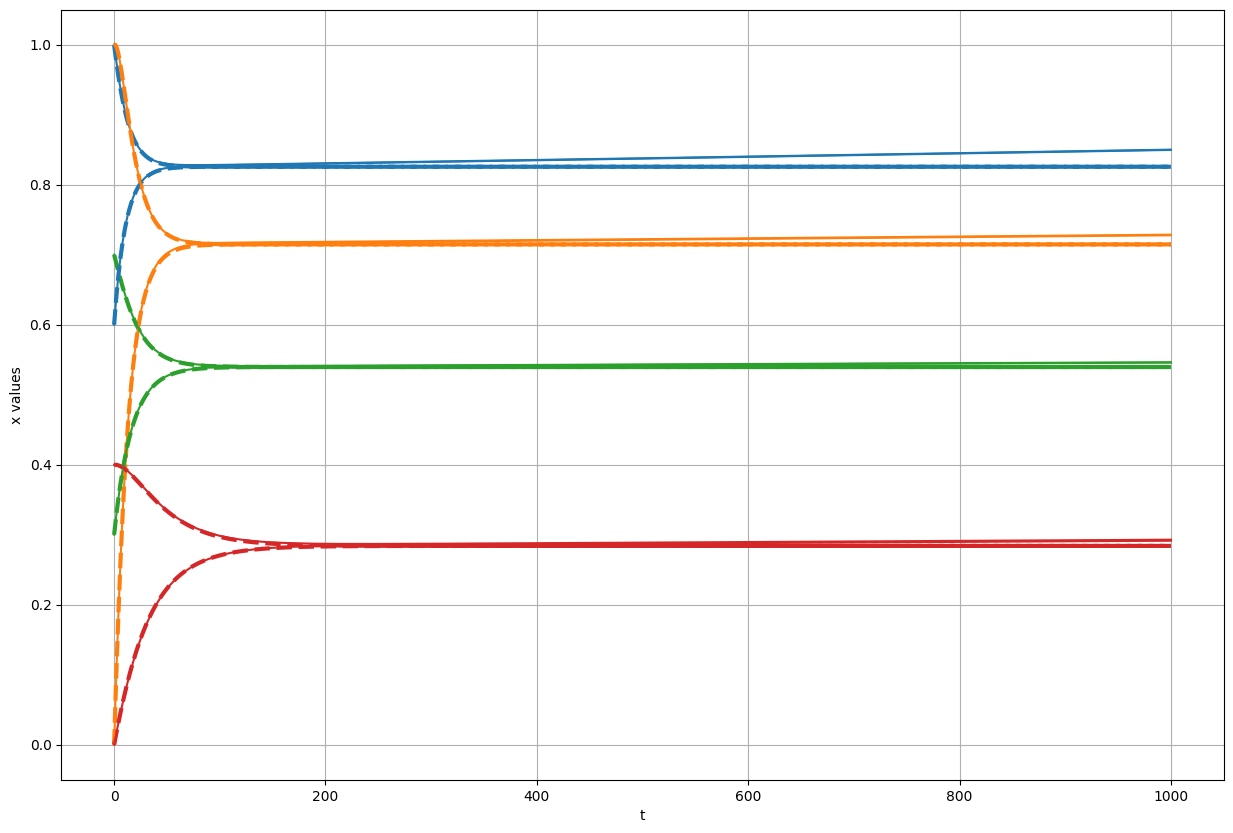

In [153]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

Ah! It drifts!
Let's check the angular map associated to the vector field:

In [ ]:
def direction_colormap(saved_model):

    # Grid size
    n = 256
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)

    #------------------------
    # TRUE
    #------------------------

    # Initialize vector field
    U = np.zeros((n, n))
    V = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            U[i, j], V[i,j] = propagator(np.array([X[i, j], Y[i, j]]), alpha, dt)
            U[i, j] -= X[i, j]
            V[i, j] -= Y[i, j]

    # Compute angle (in radians, from -pi to pi)
    angles = np.arctan2(V, U)

    # Normalize angles to [0,1] for HSV colormap
    # atan2 gives [-pi, pi], so we shift and scale
    angles_normalized = (angles + np.pi) / (2 * np.pi)

    # Convert to colors using HSV colormap (hue encodes angle)
    colors = plt.cm.hsv(angles_normalized)

    #------------------------
    # PRED
    #------------------------

    # Initialize vector field
    U_pred = np.zeros((n, n))
    V_pred = np.zeros((n, n))

    with torch.no_grad():
        for i in range(n):
            for j in range(n):
                U_pred[i, j], V_pred[i,j] = y_scaler.inverse_transform(saved_model(torch.tensor(
                            np.array([X[i, j], Y[i, j]]), dtype=torch.float32).unsqueeze(0)).numpy()).flatten()

    angles_pred = np.arctan2(V_pred, U_pred)
    angles_normalized_pred = (angles_pred + np.pi) / (2 * np.pi)
    colors_pred = plt.cm.hsv(angles_normalized_pred)

    #------------------------
    # COS SIM
    #------------------------

    cos_sim = np.zeros_like(U)

    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            vec_true = np.array([U[i, j], V[i, j]])
            vec_pred = np.array([U_pred[i, j], V_pred[i, j]])
        
            # avoid division by zero
            if np.linalg.norm(vec_true) == 0 or np.linalg.norm(vec_pred) == 0:
                cos_sim[i, j] = 0.0
            else:
                cos_sim[i, j] = np.dot(vec_true, vec_pred) / (np.linalg.norm(vec_true) * np.linalg.norm(vec_pred))


    #------------------------
    # PLOT
    #------------------------

    # Create 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # First plot
    axes[0].imshow(colors, origin="lower", extent=[0,1,0,1])
    axes[0].set_title("True")

    # Second plot
    axes[1].imshow(colors_pred, origin="lower", extent=[0,1,0,1])
    axes[1].set_title("Pred")

    # Third plot
    axes[2].imshow(cos_sim, origin="lower", extent=[0,1,0,1])
    axes[2].set_title("Cosine similarity")

    plt.tight_layout()
    plt.show()


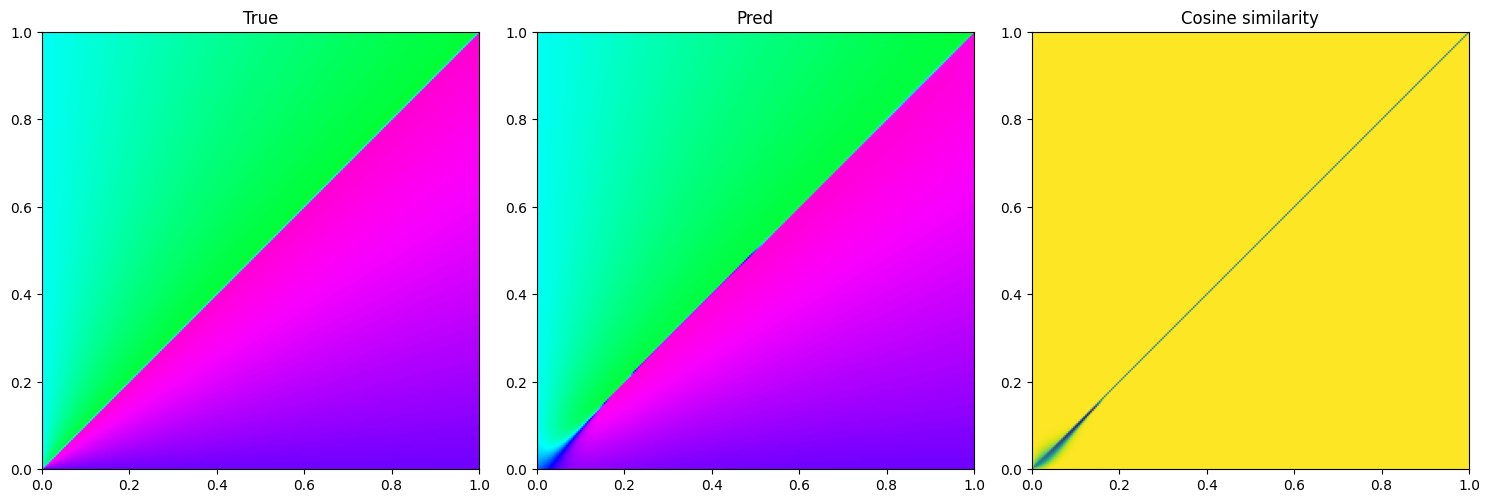

In [189]:
direction_colormap(saved_model)

Not even too bad actually. 
Furthermore it can be learnt better by inserting the cosine similarity term into the loss.